In [5]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
import pandas as pd

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
path_dir_sc_bn = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230622_154449"
path_dir_harcoded_bn = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230627_150517"
# path_file = "model_init_2.pth"

In [11]:
# state_dict = torch.load(path_file)#["state_dict"]
# alphas_init = [state_dict[e] for e in state_dict if "alpha" in e][0]
# lambdas_init = nn.Sigmoid()(alphas_init)

In [13]:
def plot_results(path_dir):
    filenames = [filename for filename in os.listdir(path_dir) if filename.endswith("pth")]
    numbers = []
    for string in filenames:
        match = re.search(r'\d+', string)  # Extracts the first occurrence of one or more digits
        if match:
            number = int(match.group())  # Converts the matched string to an integer
            numbers.append(number)
    filenames = [tup[0] for tup in sorted(zip(filenames, numbers), key=lambda x:x[1])]

    alphas, lambdas = [], []

    for file in filenames:
        path_file = os.path.join(path_dir, file)
        try:
            state_dict = torch.load(path_file)["state_dict"]
        except:
            state_dict = torch.load(path_file)
        alpha_tens = [state_dict[e] for e in state_dict if "alpha" in e][0].to(torch.device("cpu"))
        lambda_tens = nn.Sigmoid()(alpha_tens)
        alphas.append(alpha_tens)
        lambdas.append(lambda_tens)

    alphas_torch = torch.concat(alphas)
    lambdas_torch = torch.concat(lambdas)

    numb_alpha_convergences = 10
    plt.title(f"{numb_alpha_convergences} randomly picked lambda convergences")
    for i in range(numb_alpha_convergences):
        idx_rand = np.random.randint(lambdas_torch.shape[-1])
        plt.plot(sorted(numbers), lambdas_torch[:, idx_rand, idx_rand], label=f"Idx: {idx_rand}")
        plt.ylim(0, 1)
        plt.ylabel("lambda")
        plt.xlabel("Iteration")

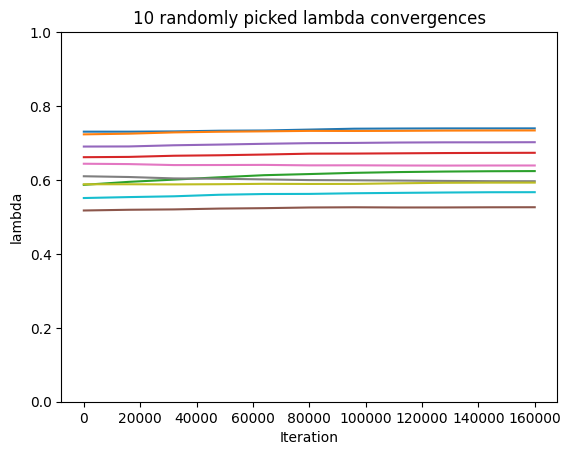

In [19]:
plot_results(path_dir_sc_bn)

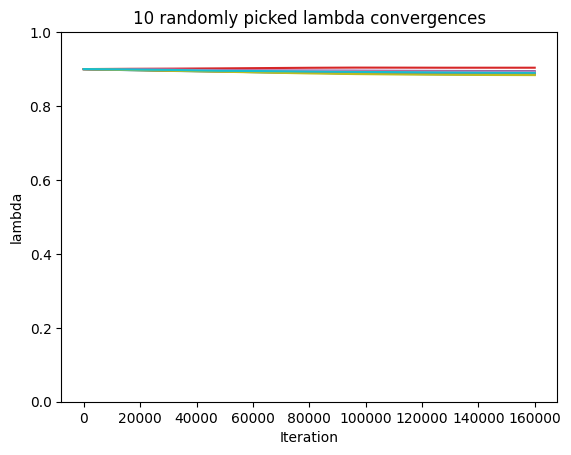

In [18]:
plot_results(path_dir_harcoded_bn)

In [39]:
filenames = [filename for filename in os.listdir(path_dir_harcoded_bn) if filename.endswith("pth")]
numbers = []
for string in filenames:
  
    match = re.search(r'\d+', string)  # Extracts the first occurrence of one or more digits
    if match:
        number = int(match.group())  # Converts the matched string to an integer
        numbers.append(number)
filenames = [tup[0] for tup in sorted(zip(filenames, numbers), key=lambda x:x[1])]

filenames

['iter_0000.pth',
 'iter_16000.pth',
 'iter_32000.pth',
 'iter_48000.pth',
 'iter_64000.pth',
 'iter_80000.pth',
 'iter_96000.pth',
 'iter_112000.pth',
 'iter_128000.pth',
 'iter_144000.pth',
 'iter_160000.pth']

In [ ]:
alphas, lambdas = [], []
for file in filenames[1:]:
        path_file = os.path.join(path_dir, file)
        try:
            state_dict = torch.load(path_file)["state_dict"]
        except:
            state_dict = torch.load(path_file)
        alpha_tens = [state_dict[e] for e in state_dict if "alpha" in e][0].to(torch.device("cpu"))
        lambda_tens = nn.Sigmoid()(alpha_tens)
        alphas.append(alpha_tens)
        lambdas.append(lambda_tens)

In [40]:
path1 = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230627_150517/iter_16000.pth"
path2 = "work_dirs/segformer_mit-b0_8xb2-160k_ade20k-512x512/20230627_150517/iter_32000.pth"

In [45]:
tens1 = torch.load(path1)["state_dict"]
tens2 = torch.load(path2)["state_dict"]

In [47]:
[tens1[e] for e in tens1][0]

tensor([[[[-1.2629e-02, -1.0369e-02, -1.4036e-02,  ..., -1.8282e-02,
           -1.6169e-02, -1.2443e-03],
          [-1.3949e-02, -9.9939e-03, -2.7017e-02,  ..., -1.3878e-03,
           -5.4221e-03,  1.0620e-02],
          [-2.1571e-02, -2.7784e-02, -6.4586e-02,  ...,  9.6658e-02,
            2.4964e-02,  1.5537e-02],
          ...,
          [-4.5541e-02, -6.6231e-02, -1.8402e-02,  ...,  3.2890e-02,
            2.4107e-02,  5.5816e-02],
          [-2.9398e-02, -3.3933e-02,  1.2287e-02,  ...,  1.1269e-01,
            1.0836e-01,  6.6769e-02],
          [-1.7158e-02, -1.9651e-03,  4.6371e-02,  ...,  3.4396e-02,
           -2.1750e-02,  1.7410e-02]],

         [[-2.4272e-03, -3.5547e-03, -4.1191e-03,  ...,  1.1182e-02,
            6.9326e-03,  9.2066e-03],
          [ 3.2118e-04, -4.8725e-04,  3.1405e-03,  ...,  3.4653e-02,
            1.9982e-02, -5.9443e-03],
          [ 1.0935e-02,  3.4509e-02,  1.9883e-03,  ...,  1.6306e-01,
            1.7296e-03, -2.7130e-02],
          ...,
     

In [52]:
np.unique([torch.equal(tens1[e], tens2[e]) for e in tens1], return_counts=True)

(array([False,  True]), array([ 16, 177]))

In [54]:
[e for e in tens1 if not torch.equal(tens1[e], tens2[e])]

['backbone.layers.3.1.2.btn_alphas',
 'decode_head.convs.0.bn.running_mean',
 'decode_head.convs.0.bn.running_var',
 'decode_head.convs.0.bn.num_batches_tracked',
 'decode_head.convs.1.bn.running_mean',
 'decode_head.convs.1.bn.running_var',
 'decode_head.convs.1.bn.num_batches_tracked',
 'decode_head.convs.2.bn.running_mean',
 'decode_head.convs.2.bn.running_var',
 'decode_head.convs.2.bn.num_batches_tracked',
 'decode_head.convs.3.bn.running_mean',
 'decode_head.convs.3.bn.running_var',
 'decode_head.convs.3.bn.num_batches_tracked',
 'decode_head.fusion_conv.bn.running_mean',
 'decode_head.fusion_conv.bn.running_var',
 'decode_head.fusion_conv.bn.num_batches_tracked']

In [56]:
[e for e in tens1 if "decode_head" in e]

['decode_head.conv_seg.weight',
 'decode_head.conv_seg.bias',
 'decode_head.convs.0.conv.weight',
 'decode_head.convs.0.bn.weight',
 'decode_head.convs.0.bn.bias',
 'decode_head.convs.0.bn.running_mean',
 'decode_head.convs.0.bn.running_var',
 'decode_head.convs.0.bn.num_batches_tracked',
 'decode_head.convs.1.conv.weight',
 'decode_head.convs.1.bn.weight',
 'decode_head.convs.1.bn.bias',
 'decode_head.convs.1.bn.running_mean',
 'decode_head.convs.1.bn.running_var',
 'decode_head.convs.1.bn.num_batches_tracked',
 'decode_head.convs.2.conv.weight',
 'decode_head.convs.2.bn.weight',
 'decode_head.convs.2.bn.bias',
 'decode_head.convs.2.bn.running_mean',
 'decode_head.convs.2.bn.running_var',
 'decode_head.convs.2.bn.num_batches_tracked',
 'decode_head.convs.3.conv.weight',
 'decode_head.convs.3.bn.weight',
 'decode_head.convs.3.bn.bias',
 'decode_head.convs.3.bn.running_mean',
 'decode_head.convs.3.bn.running_var',
 'decode_head.convs.3.bn.num_batches_tracked',
 'decode_head.fusion_conv.

In [50]:
torch.equal([tens1[e] for e in tens1][0], [tens2[e] for e in tens2][0])

True

In [22]:
path_segformer_seulki = "segformer_inmiddle/vis_data/20230622_130814.json"

In [23]:
df_seulki = pd.read_json(path_segformer_seulki, lines = True)
df_seg_authors = pd.read_json("segformer_mit_author_training.json", lines = True).head(len(df_seulki))


In [24]:
df_seg_authors["env_info"].iloc[0]

'sys.platform: linux\nPython: 3.7.6 (default, Jan  8 2020, 19:59:22) [GCC 7.3.0]\nCUDA available: True\nGPU 0,1,2,4,5,6,7: TITAN Xp\nGPU 3: GeForce GTX 1080 Ti\nCUDA_HOME: /mnt/lustre/share/polaris/dep/cuda-9.0-cudnn7.6.5\nNVCC: Cuda compilation tools, release 9.0, V9.0.176\nGCC: gcc (GCC) 5.4.0\nPyTorch: 1.5.0\nPyTorch compiling details: PyTorch built with:\n  - GCC 5.4\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v0.21.1 (Git Hash 912ce228837d1ce28e1a61806118835de03f5751)\n  - OpenMP 201307 (a.k.a. OpenMP 4.0)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 9.0\n  - NVCC architecture flags: -gencode;arch=compute_52,code=sm_52;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_70,code=compute_70\n  - CuDNN 7.6.5\n  - Magma 2.5.0\n  - Build settings: BLAS=MKL, BUILD_T

In [25]:
for col in df_seg_authors.columns: print(col)

env_info
seed
exp_name
mmseg_version
config
CLASSES
PALETTE
mode
epoch
iter
lr
memory
data_time
decode.loss_seg
decode.acc_seg
loss
time
aAcc
mIoU
mAcc
IoU.wall
IoU.building
IoU.sky
IoU.floor
IoU.tree
IoU.ceiling
IoU.road
IoU.bed 
IoU.windowpane
IoU.grass
IoU.cabinet
IoU.sidewalk
IoU.person
IoU.earth
IoU.door
IoU.table
IoU.mountain
IoU.plant
IoU.curtain
IoU.chair
IoU.car
IoU.water
IoU.painting
IoU.sofa
IoU.shelf
IoU.house
IoU.sea
IoU.mirror
IoU.rug
IoU.field
IoU.armchair
IoU.seat
IoU.fence
IoU.desk
IoU.rock
IoU.wardrobe
IoU.lamp
IoU.bathtub
IoU.railing
IoU.cushion
IoU.base
IoU.box
IoU.column
IoU.signboard
IoU.chest of drawers
IoU.counter
IoU.sand
IoU.sink
IoU.skyscraper
IoU.fireplace
IoU.refrigerator
IoU.grandstand
IoU.path
IoU.stairs
IoU.runway
IoU.case
IoU.pool table
IoU.pillow
IoU.screen door
IoU.stairway
IoU.river
IoU.bridge
IoU.bookcase
IoU.blind
IoU.coffee table
IoU.toilet
IoU.flower
IoU.book
IoU.hill
IoU.bench
IoU.countertop
IoU.stove
IoU.palm
IoU.kitchen island
IoU.computer
IoU

In [26]:
df_seg_authors

,env_info,seed,exp_name,mmseg_version,config,CLASSES,PALETTE,mode,epoch,iter,...,Acc.pier,Acc.crt screen,Acc.plate,Acc.monitor,Acc.bulletin board,Acc.shower,Acc.radiator,Acc.glass,Acc.clock,Acc.flag
0,"sys.platform: linux\nPython: 3.7.6 (default, J...",NaN,segformer_mit-b0_512x512_160k_ade20k.py,0.15.0+d5fd29a,"norm_cfg = dict(type='SyncBN', requires_grad=T...","[wall, building, sky, floor, tree, ceiling, ro...","[[120, 120, 120], [180, 120, 120], [6, 230, 23...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_combined = pd.concat([df_seulki["loss"], df_seg_authors["loss"]], axis=1)
df_combined.columns = ["loss_seulki", "loss_seg_authors"]

In [28]:
print(df_seg_authors["config"].iloc[0])

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/mit_b0.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=32,
        num_stages=4,
        num_layers=[2, 2, 2, 2],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        pretrained='pretrain/mit_b0.pth'),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[32, 64, 160, 256],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=150,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test

In [29]:
df_seg_authors["mIoU"][df_seg_authors["mIoU"].notnull()]

320    0.3005
Name: mIoU, dtype: float64

In [30]:
df_seg_authors

,env_info,seed,exp_name,mmseg_version,config,CLASSES,PALETTE,mode,epoch,iter,...,Acc.pier,Acc.crt screen,Acc.plate,Acc.monitor,Acc.bulletin board,Acc.shower,Acc.radiator,Acc.glass,Acc.clock,Acc.flag
0,"sys.platform: linux\nPython: 3.7.6 (default, J...",NaN,segformer_mit-b0_512x512_160k_ade20k.py,0.15.0+d5fd29a,"norm_cfg = dict(type='SyncBN', requires_grad=T...","[wall, building, sky, floor, tree, ceiling, ro...","[[120, 120, 120], [180, 120, 120], [6, 230, 23...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,22.0,26800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_seg_authors.head(7)

,env_info,seed,exp_name,mmseg_version,config,CLASSES,PALETTE,mode,epoch,iter,...,Acc.pier,Acc.crt screen,Acc.plate,Acc.monitor,Acc.bulletin board,Acc.shower,Acc.radiator,Acc.glass,Acc.clock,Acc.flag
0,"sys.platform: linux\nPython: 3.7.6 (default, J...",NaN,segformer_mit-b0_512x512_160k_ade20k.py,0.15.0+d5fd29a,"norm_cfg = dict(type='SyncBN', requires_grad=T...","[wall, building, sky, floor, tree, ceiling, ro...","[[120, 120, 120], [180, 120, 120], [6, 230, 23...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,1.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for col in df_seg_authors.columns:
    print(col)

env_info
seed
exp_name
mmseg_version
config
CLASSES
PALETTE
mode
epoch
iter
lr
memory
data_time
decode.loss_seg
decode.acc_seg
loss
time
aAcc
mIoU
mAcc
IoU.wall
IoU.building
IoU.sky
IoU.floor
IoU.tree
IoU.ceiling
IoU.road
IoU.bed 
IoU.windowpane
IoU.grass
IoU.cabinet
IoU.sidewalk
IoU.person
IoU.earth
IoU.door
IoU.table
IoU.mountain
IoU.plant
IoU.curtain
IoU.chair
IoU.car
IoU.water
IoU.painting
IoU.sofa
IoU.shelf
IoU.house
IoU.sea
IoU.mirror
IoU.rug
IoU.field
IoU.armchair
IoU.seat
IoU.fence
IoU.desk
IoU.rock
IoU.wardrobe
IoU.lamp
IoU.bathtub
IoU.railing
IoU.cushion
IoU.base
IoU.box
IoU.column
IoU.signboard
IoU.chest of drawers
IoU.counter
IoU.sand
IoU.sink
IoU.skyscraper
IoU.fireplace
IoU.refrigerator
IoU.grandstand
IoU.path
IoU.stairs
IoU.runway
IoU.case
IoU.pool table
IoU.pillow
IoU.screen door
IoU.stairway
IoU.river
IoU.bridge
IoU.bookcase
IoU.blind
IoU.coffee table
IoU.toilet
IoU.flower
IoU.book
IoU.hill
IoU.bench
IoU.countertop
IoU.stove
IoU.palm
IoU.kitchen island
IoU.computer
IoU